In [3]:
import numpy as np
import os, shutil
import time
import matplotlib.pyplot as plt


from keras.models import load_model


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

## Preparation des données et fonction fit

In [5]:
#Chargement du jeu de données
original_dataset_dir = r'C:\Users\aeutarici\Documents\MLDL\M2_SISE_Images_Classification'

train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))


############################################################################################################

#Definir la fonction de transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Définir le jeu de données d'entraînement
train_dataset = ImageFolder(original_dataset_dir + '/train_another', transform=transform)

# Définir le DataLoader pour les données d'entraînement
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = ImageFolder(original_dataset_dir + '/validation_another', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [57]:
# Boucle d'entraînement

def train_model(optimizer, criterion, model, val_loader, train_loader):
    train_losses = []
    val_accs = []
    val_losses = []
    train_accs = []
    train_losses= []
    val_loss = 0
    train_loss = 0
    elapsed_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        accuracy=0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            
            # Valider le modèle
            if i % 100 == 99:  # tout 100 mini-batches
                model.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for data in val_loader:
                        inputs, labels = data
                        outputs = model(inputs)
                        val_loss = criterion(outputs, labels)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                    val_accs.append(correct / total)    
                    print('Epoch %d validation accuracy: %.2f %%' % (
                        epoch + 1, 100 * correct / total))
                model.train()
                break 
            train_accs.append(accuracy/100)
            
        val_losses.append(val_loss / 100)
        train_loss = running_loss / 100
        train_losses.append(train_loss)
        elapsed_time += time.time() - start_time
        print('Epoch %d finished after %d seconds' % 
             (epoch + 1, elapsed_time))
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / (i + 1)))

    print('Finished Training')
    return train_losses, train_accs, val_accs, val_losses

## Avec le modèle pré-entrainé resnet18


In [41]:
# Charger un modèle pré-entraîné (ici ResNet18)
model1 = torchvision.models.resnet18(weights=True)

# Définir la dernière couche en fonction du nombre de classes
num_classes = 2 
model1.fc = nn.Linear(512, num_classes)

# Définir les paramètres à optimiser
params_to_update = []
for name, param in model1.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
# Configurer l'optimiseur 
optimizer1 = optim.Adam(params_to_update, lr=0.001)
optimizer2 = optim.RMSprop(params_to_update, lr=0.001)


# Définir la fonction de perte (cross-entropy)
criterion = nn.CrossEntropyLoss()

# Définir le nombre d'épochs
num_epochs = 3

In [58]:
#Resnet18 avec l'optimizer Adam
train_losses1, train_accs1, val_accs1, val_losses1 = train_model(optimizer1, criterion, model1, val_loader, train_loader)

Epoch 1 validation accuracy: 96.40 %
Epoch 1 finished after 93 seconds
[1,   100] loss: 0.131
Epoch 2 validation accuracy: 97.40 %
Epoch 2 finished after 186 seconds
[2,   100] loss: 0.114
Epoch 3 validation accuracy: 96.95 %
Epoch 3 finished after 283 seconds
[3,   100] loss: 0.102
Finished Training


In [63]:
len(train_accs1)

297

ValueError: x and y must have same first dimension, but have shapes (297,) and (3,)

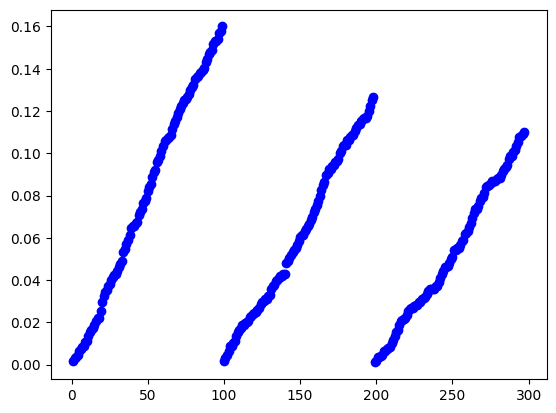

In [60]:
#training_acc = train_accs1
validation_acc = val_accs1
training_loss = train_losses1
validation_loss = val_losses1
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Resnet18 avec l'optimizer RMSprop
train_losses2, val_accuracies2, val_losses2 = train_model(optimizer2, criterion, model1, val_loader, train_loader)

In [ ]:
plt.plot(train_losses2, label='Training Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies2, label='Validation Accuracy')
plt.legend()
plt.show()

 ### Modification de plusieurs couches de ResNet18
 

In [7]:
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, num_classes)

hidden_size=256
model1.add_module("fc1", nn.Linear(num_features, hidden_size))
model1.add_module("relu1", nn.ReLU())
model1.add_module("fc2", nn.Linear(hidden_size, num_classes))


In [ ]:
#Resnet18  modifié avec l'optimizer Adam
train_losses1b, val_accuracies1b, val_losses1b = train_model(optimizer1, criterion, model1, val_loader, train_loader)

In [ ]:
plt.plot(train_losses1b, label='Training Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies1b, label='Validation Accuracy')
plt.legend()
plt.show()

## Avec le modèle pré-entrainé Inception_v3

In [ ]:
# Charger le modèle pré-entraîné 
model2 = torchvision.models.inception3(weights=True)

# Définir la dernière couche en fonction du nombre de classes
num_classes = 2 
model.fc = nn.Linear(2048, num_classes)

# Définir les paramètres à optimiser
params_to_update = []
for name, param in model1.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
# Configurer l'optimiseur 
optimizer1 = optim.Adam(params_to_update, lr=0.001)
optimizer2 = optim.RMSprop(params_to_update, lr=0.001)

# Définir la fonction de perte (cross-entropy)
criterion = nn.CrossEntropyLoss()

# Définir le nombre d'épochs
num_epochs = 15

In [ ]:
#Inception_v3 avec l'optimizer Adam
train_losses3, val_accuracies3, val_losses3 = train_model(optimizer1, criterion, model2, val_loader, train_loader)

In [ ]:
plt.plot(train_losses3, label='Training Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies3, label='Validation Accuracy')
plt.legend()
plt.show()

## Avec le modèle pré-entrainé VGG16

In [ ]:
# Charger le modèle pré-entraîné 
model3 = torchvision.models.VGG16(weights=True)

# Définir la dernière couche en fonction du nombre de classes
num_classes = 2 
model3.classifier[6] = nn.Linear(4096, num_classes)

# Définir les paramètres à optimiser
params_to_update = []
for name, param in model1.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
# Configurer l'optimiseur 
optimizer1 = optim.Adam(params_to_update, lr=0.001)
optimizer2 = optim.RMSprop(params_to_update, lr=0.001)

# Définir la fonction de perte (cross-entropy)
criterion = nn.CrossEntropyLoss()

# Définir le nombre d'épochs
num_epochs = 15

In [ ]:
#VGG16 avec l'optimizer Adam
train_losses4, val_accuracies4, val_losses4 = train_model(optimizer1, criterion, model3, val_loader, train_loader)